<a href="https://colab.research.google.com/github/Surkelly/projectMgmt/blob/main/GeneratePVFromMultipleProjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project planned value calculator
## Introduction
When we have many projects, it can be difficult to estimate the planned progress.

## Objectives
The purpose of this notebook is to:
a. calculate the Planned Value (PV) from project data (i.e. id, start, end, and cost values (from a flat csv or excel file);
b. using a defined function (e.g. sigmoid function); and
c. output it into a flat csv file

## Import Libraries
We import the following libraries.

In [69]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


## Import Data


In [39]:
#Option 1: Import local file
#from google.colab import files
#uploaded = files.upload()
#import io
#df = pd.read_csv(io.BytesIO(uploaded["sample_project_data.csv"]))

In [70]:
#Option 2: Import data from Google Sheets
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('sample_project_data').worksheet('baseline_00')

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(rows)
#assign top row as header row
df.columns = df.iloc[0]
#drop top row
df.drop(0, inplace = True)
#reset index
df.reset_index(drop=True,inplace=True)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Project  25 non-null     object
 1   P_Start  25 non-null     object
 2   P_End    25 non-null     object
 3   P_Cost   25 non-null     object
dtypes: object(4)
memory usage: 928.0+ bytes


In [72]:
df.head()

,Project,P_Start,P_End,P_Cost
0,Repair/Upgrade shore power system Jetty Alpha,27-Sep-19,16-Oct-20,"$781,727.00"
1,Repair/Upgrade shipshed power system Jetty Bravo,27-Sep-19,04-Jan-21,"$1,394,021.00"
2,Repair/Upgrade of building service installations,01-Aug-19,02-Apr-21,"$188,580.00"
3,Refurbishment of social room shipshed Jetty Bravo,16-Sep-19,02-Apr-21,"$81,467.00"
4,Refurbishment of offices in shipshed Jetty Bravo,16-Sep-19,02-Apr-21,"$203,666.00"


## Clean Data

In [73]:
#keep only the columns we need
#df = df.drop(columns = ['P_Duration','A_Duration'])
#df = df[['Project','P_Start','P_End','P_Cost','A_Start','A_End','A_Cost']]
df = df[['Project','P_Start','P_End','P_Cost']]

In [74]:
#correct data type
#convert date columns to date type
df['P_Start'] = pd.to_datetime(df['P_Start'])
df['P_End'] = pd.to_datetime(df['P_End'])
#df['A_Start'] = pd.to_datetime(df['A_Start'])
#df['A_End'] = pd.to_datetime(df['A_End'])

#convert string columns to numeric
#https://pbpython.com/currency-cleanup.html
df['P_Cost'] = df['P_Cost'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)
#df['A_Cost'] = df['A_Cost'].apply(lambda x: x.replace('$', '').replace(',', '')
#                                if isinstance(x, str) else x).astype(float)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Project  25 non-null     object        
 1   P_Start  25 non-null     datetime64[ns]
 2   P_End    25 non-null     datetime64[ns]
 3   P_Cost   25 non-null     float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 928.0+ bytes


## Define helper functions
Define some helper functions to help with the calculations later.

In [76]:
#Define helper functions

#takes the dataset and uses the P_Start, P_End, and Cost columns to calculate PV vs Date using s-curve (sigmoid)
def Estimate_PV(start,end,cost):
  #import libraries
  import datetime
  import numpy as np
  from scipy.special import expit
  #calculate duration and convert from datetime to int
  duration = end - start
  duration_days = duration.days
  
  #define duration_range for sigmoid
  duration_range = np.linspace(-5,5,duration_days+1)
  
  #model sigmoid
  curve_sigmoid = expit(duration_range)
  curve_sigmoid[0] = 0
  curve_sigmoid[-1] = 1
  
  #generate date_list
  date_list = [start + datetime.timedelta(days = x) for x in range(duration_days + 1)]
  
  #scale curve to planned value
  PV = curve_sigmoid*cost
  
  #Option 1:Store result in array list
  #array = [date_list,PV]
  #return array

  #option 2: Store result in dataframe
  dates = np.array(date_list)
  values = np.array(PV)
  dataset = pd.DataFrame({'date': dates, 'pv':values})
  return dataset

In [82]:
#takes the dataset, calculates p_curve, and stores it into a dictionary
def getPV(data):
  df_dict = {}
  for ind in data.index:
    #get cell values
    projectName = data['Project'][ind] 
    start = data['P_Start'][ind]
    end = data['P_End'][ind]
    cost = data['P_Cost'][ind]

    #calculate the pv_curve
    pv_curve = Estimate_PV(start,end,cost)
    
    #store into a dictionary
    pv_dict[projectName] = pv_curve

## Transform data

In [193]:
#define empty dictionary
pv_dict={}
#call function to create and store pv-cruves into pv_dict
getPV(df)

In [194]:
#create range X from 1 Jan 2019 to 31 Dec 2029
datelist = pd.date_range(start="2019-01-01",end="2029-12-31").to_pydatetime().tolist()
#convert to dataframe
df_date = pd.DataFrame(datelist, columns=['date'])
df_date['pv'] = 0.00
#store df_date into last index of pv_dict
pv_dict["date_axis"] = df_date

In [195]:
#iteratively merge df_date with dfs in pv_dict
from functools import partial, reduce

my_reduce = partial(pd.merge, on="date", how = "outer")
merged_df = reduce(my_reduce,pv_dict.values())

#reorder date column, and reset row index
merged_df.sort_values(by=['date'],inplace=True)
merged_df.reset_index(drop=True,inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'pv_x'} in the result is deprecated and will raise a MergeError in a future version.
  """


In [196]:
#reinstate headers

#extract headers & and append start of list as date (this'll be used later)
list_header = df['Project'].to_numpy().tolist()
list_header.insert(0,'date')

#reset headers and rename with col index (this'll be used for renaming later)
merged_df.columns = pd.RangeIndex(merged_df.columns.size)

#rename headers
last_col = merged_df.shape[1]
merged_df.rename(columns = dict(zip(merged_df.columns[0:last_col],list_header)),inplace=True)

#drop last column
merged_df.drop(columns=merged_df.columns[-1],
               axis = 1,
               inplace = True)

In [198]:
#forward fill
merged_df.fillna(method='ffill', inplace = True)

#replace NaN valeus with zeros
merged_df = merged_df.replace(np.nan,0)

#sum all columns
merged_df['sum_pv'] = merged_df.sum(axis=1)

#add new column with % completed
merged_df['percent_pv'] = merged_df['sum_pv']/merged_df['sum_pv'].max()

#store in pv_df
pv_df = merged_df[['date','sum_pv','percent_pv']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


## Visualize Data

### Plot Sum PV vs D

### Plot PV vs Date

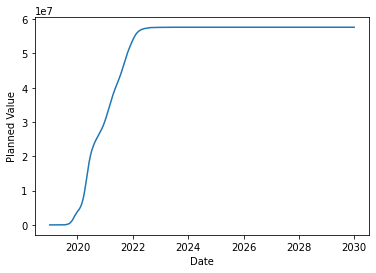

In [199]:
#assign to x and y
x = pv_df['date']
y = pv_df['sum_pv']

#https://stackoverflow.com/questions/37414916/pythons-matplotlib-plotting-in-wrong-order
x, y = zip(*sorted(zip(x,y)))

plt.plot(x,y)
plt.xlabel('Date')
plt.ylabel('Planned Value')
plt.show()

### Plot % Complete vs Date

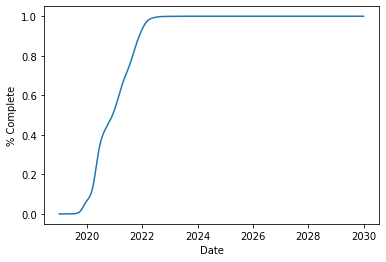

In [52]:
#assign to x and y
x = pv_df['date']
y = pv_df['percent_pv']

#https://stackoverflow.com/questions/37414916/pythons-matplotlib-plotting-in-wrong-order
x, y = zip(*sorted(zip(x,y)))

plt.plot(x,y)
plt.xlabel('Date')
plt.ylabel('% Complete')
plt.show()

In [53]:
#lookup sum at specific dates
lookup_date = "2019-03-01"
lookup_sum_pv = pv_df.loc[pv_df['date'] == lookup_date, "sum_pv"]
lookup_percent_pv = pv_df.loc[pv_df['date'] == lookup_date, "percent_pv"]

print("On ",lookup_date,", PV is: ", lookup_sum_pv, " and ", "% pv is: ", lookup_percent_pv)

On  2019-03-01 , PV is:  59    0.0
Name: sum_pv, dtype: float64  and  % pv is:  59    0.0
Name: percent_pv, dtype: float64


## Export Data to .csv

In [192]:
#export to csv
from google.colab import files
merged_df.to_csv('pv.csv')
files.download('pv.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Write to Google Sheet

In [200]:
#set the google worksheet to write to & ckear it
wsResults = gc.open('sample_project_data').worksheet('pv_results')
wsResults.clear()

{'clearedRange': 'pv_results!A1:Z4019',
 'spreadsheetId': '1vgOiqIaUbPNr02N4ar4lMmxVHwDzsfDTZW0H7Ir7Byk'}

In [201]:
#prepare the data to write
#https://www.youtube.com/watch?v=cN7W2EPM-dw&ab_channel=LearnGoogleSpreadsheets
#convert timedate to string
merged_df['date'] = merged_df['date'].astype(str)

#create list of lists
lOfLists = merged_df.to_numpy().tolist()
#get headers
headers = merged_df.columns.to_list()
#combine into dataToWrite
dataToWrite = [headers] + lOfLists

In [202]:
#write to worksheet
wsResults.update(None, dataToWrite)

{'spreadsheetId': '1vgOiqIaUbPNr02N4ar4lMmxVHwDzsfDTZW0H7Ir7Byk',
 'updatedCells': 112532,
 'updatedColumns': 28,
 'updatedRange': 'pv_results!A1:AB4019',
 'updatedRows': 4019}